In [1]:
from codes.data_utils import set_seed

import codes.Spain.data_utils_spain
import codes.Spain.preprocess_covid_spain
import importlib
import codes.data_utils

importlib.reload(codes.Spain.data_utils_spain)
importlib.reload(codes.Spain.preprocess_covid_spain)
importlib.reload(codes.data_utils)

from codes.Spain.data_utils_spain import *
from codes.Spain.preprocess_covid_spain import *
from codes.data_utils import *

In [2]:
set_seed(42)
centrality_df = pd.read_csv("data/Spain/centrality_provinces.csv")

In [3]:
mobility_df = clean_spanish_mobility_data(
    file_path="data/Spain/Spanish-Mobility-Raw.xlsx",
    centrality_path="data/Spain/centrality_provinces.csv",
    save_path="data/Spain/mobility_cleaned_final.csv"
)

cities = sorted(set(mobility_df['origin']).union(set(mobility_df['destination'])))
cities_index = {cid: i for i, cid in enumerate(cities)}
N = len(cities)
print(f"Number of Cities: {N}")

avg_matrix = pd.DataFrame(0.0, index=cities, columns=cities)
for _, row in mobility_df.iterrows():
    i, j, w = row['origin'], row['destination'], row['weight']
    avg_matrix.at[i, j] = w
    
print("Shape of avg_matrix:", avg_matrix.shape)

[✓] Final cleaned mobility data saved to: data/Spain/mobility_cleaned_final.csv
Number of Cities: 52
Shape of avg_matrix: (52, 52)


In [4]:
cities = sorted(centrality_df['nomemun'].unique())
avg_matrix = pd.DataFrame(0.0, index=cities, columns=cities)
for _, row in mobility_df.iterrows():
    i, j, w = row['PROVINCIA ORIGEN'], row['PROVINCIA DESTINO'], row['weight']
    avg_matrix.at[i, j] = w

pop_df = pd.read_csv("data/Spain/final_cleaned_population_by_province_2025.csv")
scaler = MinMaxScaler()
pop_df["Population_2025_Normalized"] = scaler.fit_transform(pop_df[["Population_2025"]])

pop_dict = dict(zip(pop_df["Province"], pop_df["Population_2025_Normalized"]))
node_pop_features = [pop_dict.get(city.title().strip(), 0.0) for city in cities]

backbone_df = extract_backbone_from_avg_matrix(avg_matrix, cities, alpha=0.01, top_k=5)
pyg_data = build_pyg_graph_from_backbone(centrality_df, backbone_df)

pyg_data.x = torch.tensor(node_pop_features).unsqueeze(1)

print(f"Backbone extracted with {len(backbone_df)} edges")
print(backbone_df.shape)
print(pyg_data)

[✓] Extracting backbone using pij < 0.01 and top-5 neighbors
[✓] Filtered down to 275 edges from 2478
[✓] Graph built with 52 nodes and 180 edges.
[✓] Converted to PyTorch Geometric format.
Backbone extracted with 275 edges
(275, 7)
Data(edge_index=[2, 360], weight=[360], edge_attr=[360, 1], num_nodes=52, x=[52, 1])


In [5]:
# Normalize edges so (A, B) and (B, A) are treated the same
normalized_edges = backbone_df.apply(
    lambda row: tuple(sorted([row['source'], row['target']])), axis=1
)

num_unique_edges = len(set(normalized_edges))
print(f"Unique undirected edges: {num_unique_edges}")

Unique undirected edges: 180


In [6]:
df_covid = pd.read_csv("data/Spain/provincias_covid19_datos_sanidad_nueva_serie.csv")
filtered_covid_df = filter_and_scale_spanish_covid_by_centrality(df_covid)

city_case_counts = filtered_covid_df['cod_ine'].value_counts().sort_index()
print(filtered_covid_df.head(100000))

[✓] Filtered to 52 provinces, 40,872 rows.
[✓] Applied Z-score normalization on daily cases (Casos).
[✓] Saved filtered + scaled Spanish COVID data to 'data/Spain/filtered_scaled_covid.csv'.
            Fecha  cod_ine         provincia  Casos  Fallecidos  \
0      2020-01-01        0         No consta      0           0   
1      2020-01-01        1       Araba/Álava      0           0   
2      2020-01-01        2          Albacete      0           0   
3      2020-01-01        3  Alicante/Alacant      0           0   
4      2020-01-01        4           Almería      0           0   
...           ...      ...               ...    ...         ...   
41652  2022-02-24       47        Valladolid      0           0   
41653  2022-02-24       48           Bizkaia     15           0   
41654  2022-02-24       49            Zamora      0           0   
41655  2022-02-24       50          Zaragoza      0           0   
41656  2022-02-24       51             Ceuta      0           0   

    

In [7]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("cpu")
    print('Using cpu')
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Using cpu


In [8]:
# Rename columns for compatibility
spain_covid_df = (
    filtered_covid_df
    .rename(columns={"cod_ine": "ibgeID", "Fecha": "date"})  # 🔁 Rename to match expected schema
)


X_train_slide, X_test_slide, Y_train_slide, Y_test_slide = generate_sliding_temporal_graph_data(
    spain_covid_df,
    input_window=14,
    output_window=1,
    feature_column="z_newCases",
    device=device,
    train_split=0.8
)

[✓] Sliding window: X torch.Size([772, 14, 52, 1]), Y torch.Size([772, 1, 52, 1])
[✓] Train: torch.Size([617, 14, 52, 1]), Test: torch.Size([155, 14, 52, 1])


In [16]:
import codes.models.global_spatiotemporal_model
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

importlib.reload(codes.models.global_spatiotemporal_model)

from codes.models.global_spatiotemporal_model import SpatiotemporalTransformer

# Number of nodes (cities)
N = pyg_data.num_nodes

model = SpatiotemporalTransformer(
    input_dim=1,         # One feature per city per day: "newCases"
    gcn_dim=1,           # No static node features (population, centrality) passed
    hidden_dim=64,       # Transformer + GCN hidden size
    nhead=8,             # Number of transformer heads
    num_layers=1,        # Transformer layers
    num_nodes=N,         # Number of nodes in the graph
    forecast_dim=1       # Predict one value per node (1-day ahead cases)
).to(device)

# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# Scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.7)  # reduce LR by half every 5 epochs

In [17]:
model.load_state_dict(torch.load("models/Global-Spatiotemporal-Spain-Current-Best-0-7903.pth"))
model.eval()  # Optional but good practice for inference

SpatiotemporalTransformer(
  (input_proj): Linear(in_features=1, out_features=64, bias=True)
  (spatial_encoder): GCNSpatialEncoder(
    (gcn1): GCNConv(1, 64)
    (gcn2): GCNConv(64, 64)
    (relu): ReLU()
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.7, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.7, inplace=False)
        (dropout2): Dropout(p=0.7, inplace=False)
      )
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (

In [18]:
from torch.utils.data import Dataset, DataLoader

class CovidGraphDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [19]:
batch_size = 128  # You can tune this based on your GPU

train_dataset = CovidGraphDataset(X_train_slide, Y_train_slide)
test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [20]:
edge_index = pyg_data.edge_index.to(device)
edge_weight = pyg_data.edge_attr.view(-1).to(device)

In [259]:
from tqdm import tqdm

num_epochs = 60
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"🧠 Epoch {epoch+1}/{num_epochs}", position=0, leave=True)

    for batch_X, batch_Y in pbar:
        batch_X = batch_X.to(device)  # [B, T, N, F]
        batch_Y = batch_Y.to(device)  # [B, N, 1]
        batch_Y = batch_Y.squeeze(1)  # from [B, 1, N, 1] → [B, N, 1]

        optimizer.zero_grad()
        output = model(batch_X, edge_index, edge_weight, node_features=pyg_data.x.to(device))  # [B, N, 1]
        loss = criterion(output, batch_Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        current_lr = optimizer.param_groups[0]['lr']

        # Live update of progress bar
        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "LR": f"{current_lr:.6f}"
        })

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_loss:.4f}")
    scheduler.step()

🧠 Epoch 1/60: 100%|██████████| 5/5 [00:40<00:00,  8.09s/it, Loss=0.0610, LR=0.000014]


✅ Epoch 1/60 — Avg Loss: 0.0640


🧠 Epoch 2/60: 100%|██████████| 5/5 [00:36<00:00,  7.38s/it, Loss=0.0469, LR=0.000014]


✅ Epoch 2/60 — Avg Loss: 0.0614


🧠 Epoch 3/60: 100%|██████████| 5/5 [00:37<00:00,  7.48s/it, Loss=0.0572, LR=0.000014]


✅ Epoch 3/60 — Avg Loss: 0.0600


🧠 Epoch 4/60: 100%|██████████| 5/5 [00:33<00:00,  6.62s/it, Loss=0.0454, LR=0.000014]


✅ Epoch 4/60 — Avg Loss: 0.0592


🧠 Epoch 5/60: 100%|██████████| 5/5 [00:32<00:00,  6.47s/it, Loss=0.0555, LR=0.000014]


✅ Epoch 5/60 — Avg Loss: 0.0579


🧠 Epoch 6/60: 100%|██████████| 5/5 [00:33<00:00,  6.65s/it, Loss=0.0555, LR=0.000010]


✅ Epoch 6/60 — Avg Loss: 0.0580


🧠 Epoch 7/60: 100%|██████████| 5/5 [00:33<00:00,  6.65s/it, Loss=0.0544, LR=0.000010]


✅ Epoch 7/60 — Avg Loss: 0.0574


🧠 Epoch 8/60: 100%|██████████| 5/5 [00:33<00:00,  6.68s/it, Loss=0.0563, LR=0.000010]


✅ Epoch 8/60 — Avg Loss: 0.0568


🧠 Epoch 9/60: 100%|██████████| 5/5 [00:32<00:00,  6.48s/it, Loss=0.0568, LR=0.000010]


✅ Epoch 9/60 — Avg Loss: 0.0566


🧠 Epoch 10/60: 100%|██████████| 5/5 [00:32<00:00,  6.55s/it, Loss=0.0566, LR=0.000010]


✅ Epoch 10/60 — Avg Loss: 0.0568


🧠 Epoch 11/60: 100%|██████████| 5/5 [00:33<00:00,  6.62s/it, Loss=0.0698, LR=0.000007]


✅ Epoch 11/60 — Avg Loss: 0.0574


🧠 Epoch 12/60: 100%|██████████| 5/5 [00:32<00:00,  6.44s/it, Loss=0.0516, LR=0.000007]


✅ Epoch 12/60 — Avg Loss: 0.0557


🧠 Epoch 13/60: 100%|██████████| 5/5 [00:32<00:00,  6.49s/it, Loss=0.0657, LR=0.000007]


✅ Epoch 13/60 — Avg Loss: 0.0561


🧠 Epoch 14/60: 100%|██████████| 5/5 [00:32<00:00,  6.50s/it, Loss=0.0482, LR=0.000007]


✅ Epoch 14/60 — Avg Loss: 0.0561


🧠 Epoch 15/60: 100%|██████████| 5/5 [00:32<00:00,  6.57s/it, Loss=0.0553, LR=0.000007]


✅ Epoch 15/60 — Avg Loss: 0.0550


🧠 Epoch 16/60: 100%|██████████| 5/5 [00:32<00:00,  6.47s/it, Loss=0.0561, LR=0.000005]


✅ Epoch 16/60 — Avg Loss: 0.0555


🧠 Epoch 17/60: 100%|██████████| 5/5 [00:33<00:00,  6.78s/it, Loss=0.0450, LR=0.000005]


✅ Epoch 17/60 — Avg Loss: 0.0551


🧠 Epoch 18/60: 100%|██████████| 5/5 [00:32<00:00,  6.59s/it, Loss=0.0425, LR=0.000005]


✅ Epoch 18/60 — Avg Loss: 0.0544


🧠 Epoch 19/60: 100%|██████████| 5/5 [00:32<00:00,  6.52s/it, Loss=0.0662, LR=0.000005]


✅ Epoch 19/60 — Avg Loss: 0.0560


🧠 Epoch 20/60: 100%|██████████| 5/5 [00:33<00:00,  6.68s/it, Loss=0.0493, LR=0.000005]


✅ Epoch 20/60 — Avg Loss: 0.0558


🧠 Epoch 21/60: 100%|██████████| 5/5 [00:32<00:00,  6.52s/it, Loss=0.0490, LR=0.000003]


✅ Epoch 21/60 — Avg Loss: 0.0542


🧠 Epoch 22/60: 100%|██████████| 5/5 [00:33<00:00,  6.62s/it, Loss=0.0517, LR=0.000003]


✅ Epoch 22/60 — Avg Loss: 0.0561


🧠 Epoch 23/60: 100%|██████████| 5/5 [00:32<00:00,  6.56s/it, Loss=0.0643, LR=0.000003]


✅ Epoch 23/60 — Avg Loss: 0.0554


🧠 Epoch 24/60: 100%|██████████| 5/5 [00:32<00:00,  6.55s/it, Loss=0.0587, LR=0.000003]


✅ Epoch 24/60 — Avg Loss: 0.0556


🧠 Epoch 25/60: 100%|██████████| 5/5 [00:32<00:00,  6.41s/it, Loss=0.0568, LR=0.000003]


✅ Epoch 25/60 — Avg Loss: 0.0547


🧠 Epoch 26/60: 100%|██████████| 5/5 [00:33<00:00,  6.61s/it, Loss=0.0410, LR=0.000002]


✅ Epoch 26/60 — Avg Loss: 0.0551


🧠 Epoch 27/60: 100%|██████████| 5/5 [00:32<00:00,  6.45s/it, Loss=0.0517, LR=0.000002]


✅ Epoch 27/60 — Avg Loss: 0.0552


🧠 Epoch 28/60: 100%|██████████| 5/5 [00:32<00:00,  6.59s/it, Loss=0.0425, LR=0.000002]


✅ Epoch 28/60 — Avg Loss: 0.0534


🧠 Epoch 29/60: 100%|██████████| 5/5 [00:33<00:00,  6.67s/it, Loss=0.0485, LR=0.000002]


✅ Epoch 29/60 — Avg Loss: 0.0549


🧠 Epoch 30/60: 100%|██████████| 5/5 [00:32<00:00,  6.56s/it, Loss=0.0530, LR=0.000002]


✅ Epoch 30/60 — Avg Loss: 0.0550


🧠 Epoch 31/60: 100%|██████████| 5/5 [00:32<00:00,  6.55s/it, Loss=0.0458, LR=0.000002]


✅ Epoch 31/60 — Avg Loss: 0.0545


🧠 Epoch 32/60: 100%|██████████| 5/5 [00:33<00:00,  6.64s/it, Loss=0.0576, LR=0.000002]


✅ Epoch 32/60 — Avg Loss: 0.0546


🧠 Epoch 33/60: 100%|██████████| 5/5 [00:32<00:00,  6.55s/it, Loss=0.0548, LR=0.000002]


✅ Epoch 33/60 — Avg Loss: 0.0552


🧠 Epoch 34/60: 100%|██████████| 5/5 [00:32<00:00,  6.42s/it, Loss=0.0550, LR=0.000002]


✅ Epoch 34/60 — Avg Loss: 0.0551


🧠 Epoch 35/60: 100%|██████████| 5/5 [00:34<00:00,  6.95s/it, Loss=0.0431, LR=0.000002]


✅ Epoch 35/60 — Avg Loss: 0.0537


🧠 Epoch 36/60: 100%|██████████| 5/5 [00:33<00:00,  6.78s/it, Loss=0.0557, LR=0.000001]


✅ Epoch 36/60 — Avg Loss: 0.0545


🧠 Epoch 37/60: 100%|██████████| 5/5 [00:32<00:00,  6.57s/it, Loss=0.0547, LR=0.000001]


✅ Epoch 37/60 — Avg Loss: 0.0546


🧠 Epoch 38/60: 100%|██████████| 5/5 [00:33<00:00,  6.61s/it, Loss=0.0563, LR=0.000001]


✅ Epoch 38/60 — Avg Loss: 0.0552


🧠 Epoch 39/60: 100%|██████████| 5/5 [00:32<00:00,  6.53s/it, Loss=0.0604, LR=0.000001]


✅ Epoch 39/60 — Avg Loss: 0.0550


🧠 Epoch 40/60: 100%|██████████| 5/5 [00:32<00:00,  6.60s/it, Loss=0.0533, LR=0.000001]


✅ Epoch 40/60 — Avg Loss: 0.0548


🧠 Epoch 41/60: 100%|██████████| 5/5 [00:33<00:00,  6.62s/it, Loss=0.0628, LR=0.000001]


✅ Epoch 41/60 — Avg Loss: 0.0549


🧠 Epoch 42/60: 100%|██████████| 5/5 [00:33<00:00,  6.67s/it, Loss=0.0552, LR=0.000001]


✅ Epoch 42/60 — Avg Loss: 0.0543


🧠 Epoch 43/60: 100%|██████████| 5/5 [00:33<00:00,  6.74s/it, Loss=0.0444, LR=0.000001]


✅ Epoch 43/60 — Avg Loss: 0.0542


🧠 Epoch 44/60: 100%|██████████| 5/5 [00:34<00:00,  6.82s/it, Loss=0.0582, LR=0.000001]


✅ Epoch 44/60 — Avg Loss: 0.0550


🧠 Epoch 45/60: 100%|██████████| 5/5 [00:34<00:00,  6.82s/it, Loss=0.0540, LR=0.000001]


✅ Epoch 45/60 — Avg Loss: 0.0550


🧠 Epoch 46/60: 100%|██████████| 5/5 [00:36<00:00,  7.30s/it, Loss=0.0533, LR=0.000001]


✅ Epoch 46/60 — Avg Loss: 0.0547


🧠 Epoch 47/60: 100%|██████████| 5/5 [00:31<00:00,  6.39s/it, Loss=0.0590, LR=0.000001]


✅ Epoch 47/60 — Avg Loss: 0.0550


🧠 Epoch 48/60: 100%|██████████| 5/5 [00:31<00:00,  6.38s/it, Loss=0.0599, LR=0.000001]


✅ Epoch 48/60 — Avg Loss: 0.0550


🧠 Epoch 49/60: 100%|██████████| 5/5 [00:31<00:00,  6.31s/it, Loss=0.0700, LR=0.000001]


✅ Epoch 49/60 — Avg Loss: 0.0557


🧠 Epoch 50/60: 100%|██████████| 5/5 [00:34<00:00,  6.85s/it, Loss=0.0538, LR=0.000001]


✅ Epoch 50/60 — Avg Loss: 0.0536


🧠 Epoch 51/60: 100%|██████████| 5/5 [00:38<00:00,  7.61s/it, Loss=0.0478, LR=0.000000]


✅ Epoch 51/60 — Avg Loss: 0.0545


🧠 Epoch 52/60: 100%|██████████| 5/5 [00:33<00:00,  6.65s/it, Loss=0.0616, LR=0.000000]


✅ Epoch 52/60 — Avg Loss: 0.0550


🧠 Epoch 53/60: 100%|██████████| 5/5 [00:31<00:00,  6.37s/it, Loss=0.0567, LR=0.000000]


✅ Epoch 53/60 — Avg Loss: 0.0556


🧠 Epoch 54/60: 100%|██████████| 5/5 [00:30<00:00,  6.08s/it, Loss=0.0574, LR=0.000000]


✅ Epoch 54/60 — Avg Loss: 0.0547


🧠 Epoch 55/60: 100%|██████████| 5/5 [00:30<00:00,  6.17s/it, Loss=0.0467, LR=0.000000]


✅ Epoch 55/60 — Avg Loss: 0.0539


🧠 Epoch 56/60: 100%|██████████| 5/5 [00:33<00:00,  6.77s/it, Loss=0.0500, LR=0.000000]


✅ Epoch 56/60 — Avg Loss: 0.0551


🧠 Epoch 57/60: 100%|██████████| 5/5 [00:33<00:00,  6.62s/it, Loss=0.0557, LR=0.000000]


✅ Epoch 57/60 — Avg Loss: 0.0552


🧠 Epoch 58/60: 100%|██████████| 5/5 [00:30<00:00,  6.19s/it, Loss=0.0592, LR=0.000000]


✅ Epoch 58/60 — Avg Loss: 0.0551


🧠 Epoch 59/60: 100%|██████████| 5/5 [00:34<00:00,  6.80s/it, Loss=0.0535, LR=0.000000]


✅ Epoch 59/60 — Avg Loss: 0.0547


🧠 Epoch 60/60: 100%|██████████| 5/5 [00:33<00:00,  6.74s/it, Loss=0.0697, LR=0.000000]

✅ Epoch 60/60 — Avg Loss: 0.0551


In [21]:
from tqdm import tqdm

test_dataset = CovidGraphDataset(X_test_slide, Y_test_slide)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="🔍 Testing", leave=False)

    for batch_X, batch_Y in progress_bar:
        batch_X = batch_X.to(device)  # [B, T, N, 1]
        batch_Y = batch_Y.to(device)  # [B, N, 1]
        batch_Y = batch_Y.squeeze(1)

        output = model(batch_X, edge_index, edge_weight, node_features=pyg_data.x.to(device))  # [B, N, 1]

        loss = criterion(output, batch_Y)
        test_loss += loss.item()

        # Store for plotting later
        predictions.append(output.cpu())     # [B, N, 1]
        actuals.append(batch_Y.cpu())        # [B, N, 1]

        progress_bar.set_postfix({"Loss": loss.item()})

# Stack everything: [B, N, 1] -> [Total_samples, N, 1]
predictions = torch.cat(predictions, dim=0)
actuals = torch.cat(actuals, dim=0)

print(f"\n✅ Final Test Loss: {test_loss / len(test_loader):.4f}")



✅ Final Test Loss: 0.5101


In [22]:
# Flatten actuals: [156, 1, 52, 1] → [156, 52]
actual_array = actuals.squeeze(1).squeeze(-1).numpy()
pred_array = predictions.squeeze(-1).numpy()  # already [156, 52]

print("Pred shape:", pred_array.shape)
print("Actual shape:", actual_array.shape)

Pred shape: (155, 52)
Actual shape: (155, 52)


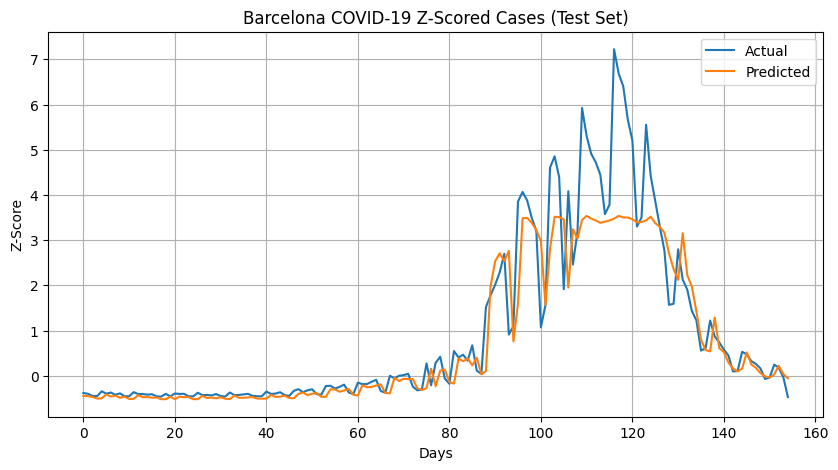

📉 RMSE for Barcelona: 0.7877
📉 SMAPE for Barcelona: 21.38%
📈 MDA for Barcelona: 50.00%


In [33]:
import matplotlib.pyplot as plt

city_name_list = list(centrality_df['nomemun'])
barcelona_index = city_name_list.index("Barcelona")

barcelona_preds = pred_array[:, barcelona_index]
barcelona_actuals = actual_array[:, barcelona_index]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(barcelona_actuals, label='Actual')
plt.plot(barcelona_preds, label='Predicted')
plt.title("Barcelona COVID-19 Z-Scored Cases (Test Set)")
plt.xlabel("Days")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.show()

# RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE = sqrt(MSE)
rmse_barcelona = np.sqrt(mean_squared_error(barcelona_actuals, barcelona_preds))
print(f"📉 RMSE for Barcelona: {rmse_barcelona:.4f}")

# SMAPE = Symmetric Mean Absolute Percentage Error
def smape(y_true, y_pred):
    return 100 * np.mean(
         np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )


def mean_directional_accuracy(actual, predicted):
    # Ensure arrays are 1D
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Compute directional changes
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)

    # Compare signs of differences
    correct_directions = (actual_diff * pred_diff) > 0

    # Compute MDA
    return 100 * np.mean(correct_directions)


smape_barcelona = smape(barcelona_actuals, barcelona_preds)
print(f"📉 SMAPE for Barcelona: {smape_barcelona:.2f}%")

mda_barcelona = mean_directional_accuracy(barcelona_actuals, barcelona_preds)
print(f"📈 MDA for Barcelona: {mda_barcelona:.2f}%")


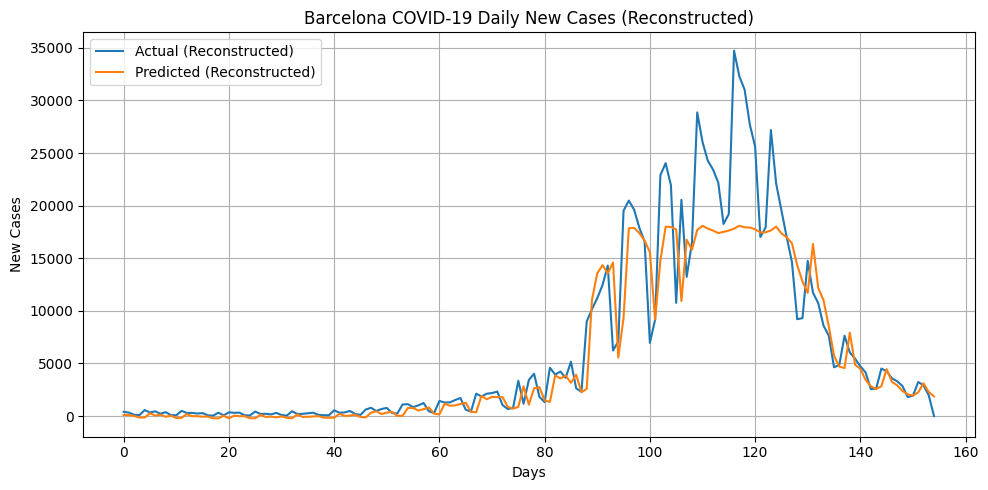

📉 RMSE for Barcelona: 3554.2005
📉 SMAPE for Barcelona: 37.85%
📈 MDA for Barcelona: 50.00%


In [25]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import mean_squared_error
import numpy as np

# Build city graph from centrality dataframe
G2 = nx.Graph()
for _, row in centrality_df.iterrows():
    city_name = row['nomemun']
    G2.add_node(city_name)

# Make sure predictions and actuals are [T, N]
pred_array = predictions.squeeze(-1).numpy()        # [T, N]
actual_array = actuals.squeeze(1).squeeze(-1).numpy()  # [T, N]

# Barcelona node name
city_name = "Barcelona"
city_id_list = list(G2.nodes())
barcelona_index = city_id_list.index(city_name)

# Get z-scored predictions and actuals
barcelona_preds_z = pred_array[:, barcelona_index]
barcelona_actuals_z = actual_array[:, barcelona_index]

# 🧠 Reconstruct actual daily cases
sp_original = df_covid[df_covid['provincia'] == city_name].copy()
sp_original['Casos'] = sp_original['Casos'].clip(lower=0)
sp_original = sp_original.sort_values('Fecha')

mean_barcelona = sp_original['Casos'].mean()
std_barcelona = sp_original['Casos'].std(ddof=0)

# 🔁 De-normalize predictions
barcelona_preds = barcelona_preds_z * std_barcelona + mean_barcelona
barcelona_actuals = barcelona_actuals_z * std_barcelona + mean_barcelona

# 📈 Plot
plt.figure(figsize=(10, 5))
plt.plot(barcelona_actuals, label='Actual (Reconstructed)')
plt.plot(barcelona_preds, label='Predicted (Reconstructed)')
plt.title("Barcelona COVID-19 Daily New Cases (Reconstructed)")
plt.xlabel("Days")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# RMSE = sqrt(MSE)
rmse_barcelona = np.sqrt(mean_squared_error(barcelona_actuals, barcelona_preds))
print(f"📉 RMSE for Barcelona: {rmse_barcelona:.4f}")

# SMAPE = Symmetric Mean Absolute Percentage Error
def smape(y_true, y_pred):
    return 100 * np.mean(
        np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )


def mean_directional_accuracy(actual, predicted):
    # Ensure arrays are 1D
    actual = np.array(actual).flatten()
    predicted = np.array(predicted).flatten()

    # Compute directional changes
    actual_diff = np.diff(actual)
    pred_diff = np.diff(predicted)

    # Compare signs of differences
    correct_directions = (actual_diff * pred_diff) > 0

    # Compute MDA
    return 100 * np.mean(correct_directions)


smape_barcelona = smape(barcelona_actuals, barcelona_preds)
print(f"📉 SMAPE for Barcelona: {smape_barcelona:.2f}%")

mda_barcelona = mean_directional_accuracy(barcelona_actuals, barcelona_preds)
print(f"📈 MDA for Barcelona: {mda_barcelona:.2f}%")

In [34]:
# Filter São Paulo full series
sp_full = filtered_covid_df[filtered_covid_df['provincia'] == city_name].sort_values('Fecha')

# Extract full z-scored series
full_z_series = sp_full['z_newCases'].tolist()
full_dates = sp_full['Fecha'].tolist()

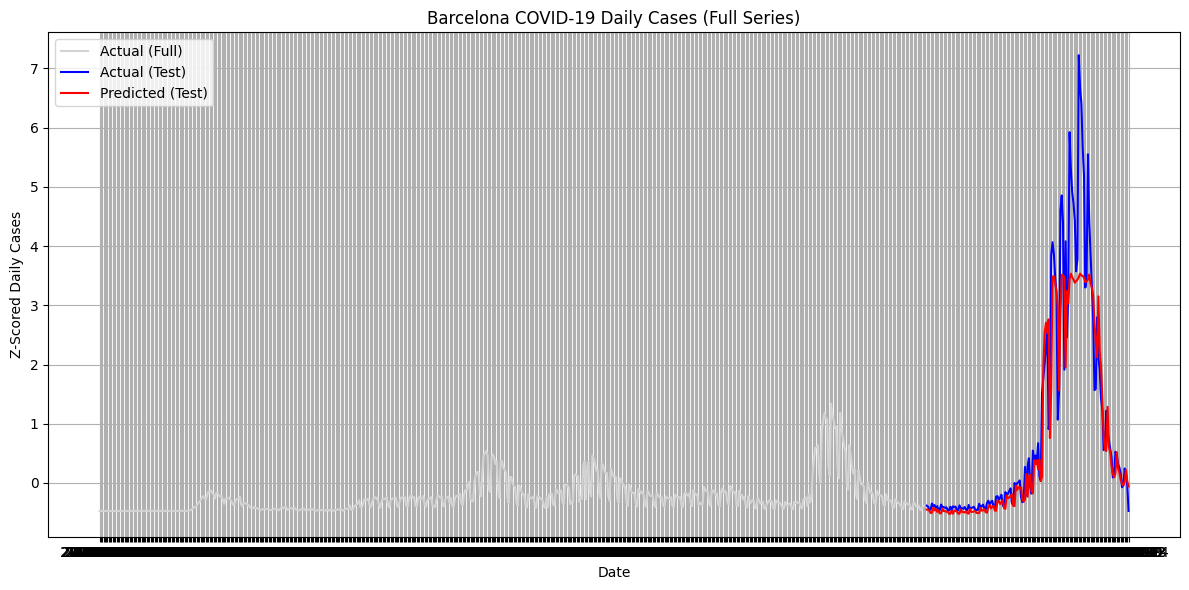

📉 RMSE for Barcelona: 0.7877


In [35]:
# Find index where test set starts (80% of the full time series segments)
start_index = len(full_z_series) - len(barcelona_actuals)

plt.figure(figsize=(12, 6))
plt.plot(full_dates, full_z_series, label='Actual (Full)', color='lightgray')
plt.plot(full_dates[start_index:], barcelona_actuals, label='Actual (Test)', color='blue')
plt.plot(full_dates[start_index:], barcelona_preds, label='Predicted (Test)', color='red')
plt.title("Barcelona COVID-19 Daily Cases (Full Series)")
plt.xlabel("Date")
plt.ylabel("Z-Scored Daily Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_squared_error
import numpy as np

rmse_sp = np.sqrt(mean_squared_error(barcelona_actuals, barcelona_preds))
print(f"📉 RMSE for Barcelona: {rmse_sp:.4f}")

In [27]:
from sklearn.metrics import mean_squared_error
import numpy as np

# pred_array and actual_array are shaped [T, N] — where T is time and N is number of cities
num_cities = pred_array.shape[1]

# Calculate RMSE for each city
rmses = []
for i in range(num_cities):
    rmse = np.sqrt(mean_squared_error(actual_array[:, i], pred_array[:, i]))
    rmses.append(rmse)

# Compute average RMSE
avg_rmse = np.mean(rmses)
print(f"📊 Average RMSE across all cities: {avg_rmse:.4f}")

# Calculate SMAPE for each city
smapes = []
for i in range(num_cities):
    smape_i = smape(actual_array[:, i], pred_array[:, i])
    smapes.append(smape_i)

# Compute average SMAPE
avg_smape = np.mean(smapes)
print(f"📊 Average SMAPE across all cities: {avg_smape:.2f}%")

mdas = []
for i in range(num_cities):
    mda_i = mean_directional_accuracy(actual_array[:, i], pred_array[:, i])
    mdas.append(mda_i)

# Compute average MDA
avg_mda = np.mean(mdas)
print(f"📈 Average MDA across all cities: {avg_mda:.2f}%")


📊 Average RMSE across all cities: 0.7957
📊 Average SMAPE across all cities: 22.25%
📈 Average MDA across all cities: 49.21%


In [30]:
pop_df = pd.read_csv("data/Spain/final_cleaned_population_by_province_2025.csv")
scaler = MinMaxScaler()
top_240_pop_cities = set(pop_df.sort_values(by="Population_2025", ascending=False)["Province"].head(40).tolist())
pop_df["Population_2025_Normalized"] = scaler.fit_transform(pop_df[["Population_2025"]])

In [31]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Map: city code → population
pop_dict = dict(zip(pop_df["Province"], pop_df["Population_2025"]))

rmse_per_100k_list = []

for i, city_code in enumerate(cities):
    if city_code not in pop_dict:
        continue  # skip if population not found

    pred_z = pred_array[:, i]
    actual_z = actual_array[:, i]

    # Restore real values
    city_df = spain_covid_df[spain_covid_df['provincia'] == city_code].copy()
    city_df['Casos'] = city_df['Casos'].clip(lower=0).sort_values()

    mean_city = city_df['Casos'].mean()
    std_city = city_df['Casos'].std(ddof=0)

    if np.isnan(std_city) or std_city == 0 or np.isnan(mean_city):
        continue  # skip cities with undefined or constant data

    pred_real = pred_z * std_city + mean_city
    actual_real = actual_z * std_city + mean_city

    population = pop_dict[city_code]

    pred_per_100k = pred_real / population * 100000
    actual_per_100k = actual_real / population * 100000

    # Check for NaNs in reconstructed arrays
    mask = ~np.isnan(actual_per_100k) & ~np.isnan(pred_per_100k)

    if mask.sum() == 0:
        continue  # skip if nothing left after masking

    rmse = np.sqrt(mean_squared_error(actual_per_100k[mask], pred_per_100k[mask]))
    rmse_per_100k_list.append(rmse)

# Final result
avg_rmse_per_100k = np.mean(rmse_per_100k_list)
print(f"📉 Average RMSE per 100k population: {avg_rmse_per_100k:.2f}")


📉 Average RMSE per 100k population: 48.25


In [28]:
city_rmse_pairs = list(zip(city_id_list, rmses))
sorted_city_rmses = sorted(city_rmse_pairs, key=lambda x: x[1])

print("\n🔝 Top 5 cities with highest RMSE:")
for city_id, rmse in sorted_city_rmses[-5:][::-1]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")

print("\n✅ Top 5 cities with lowest RMSE:")
for city_id, rmse in sorted_city_rmses[:5]:
    print(f"City ID: {city_id} — RMSE: {rmse:.4f}")



🔝 Top 5 cities with highest RMSE:
City ID: Pontevedra — RMSE: 1.0911
City ID: León — RMSE: 1.0592
City ID: Bizkaia — RMSE: 1.0454
City ID: Toledo — RMSE: 0.9954
City ID: Ávila — RMSE: 0.9596

✅ Top 5 cities with lowest RMSE:
City ID: Cuenca — RMSE: 0.5054
City ID: Ourense — RMSE: 0.5333
City ID: Las Palmas — RMSE: 0.5656
City ID: Lleida — RMSE: 0.6334
City ID: Melilla — RMSE: 0.6558


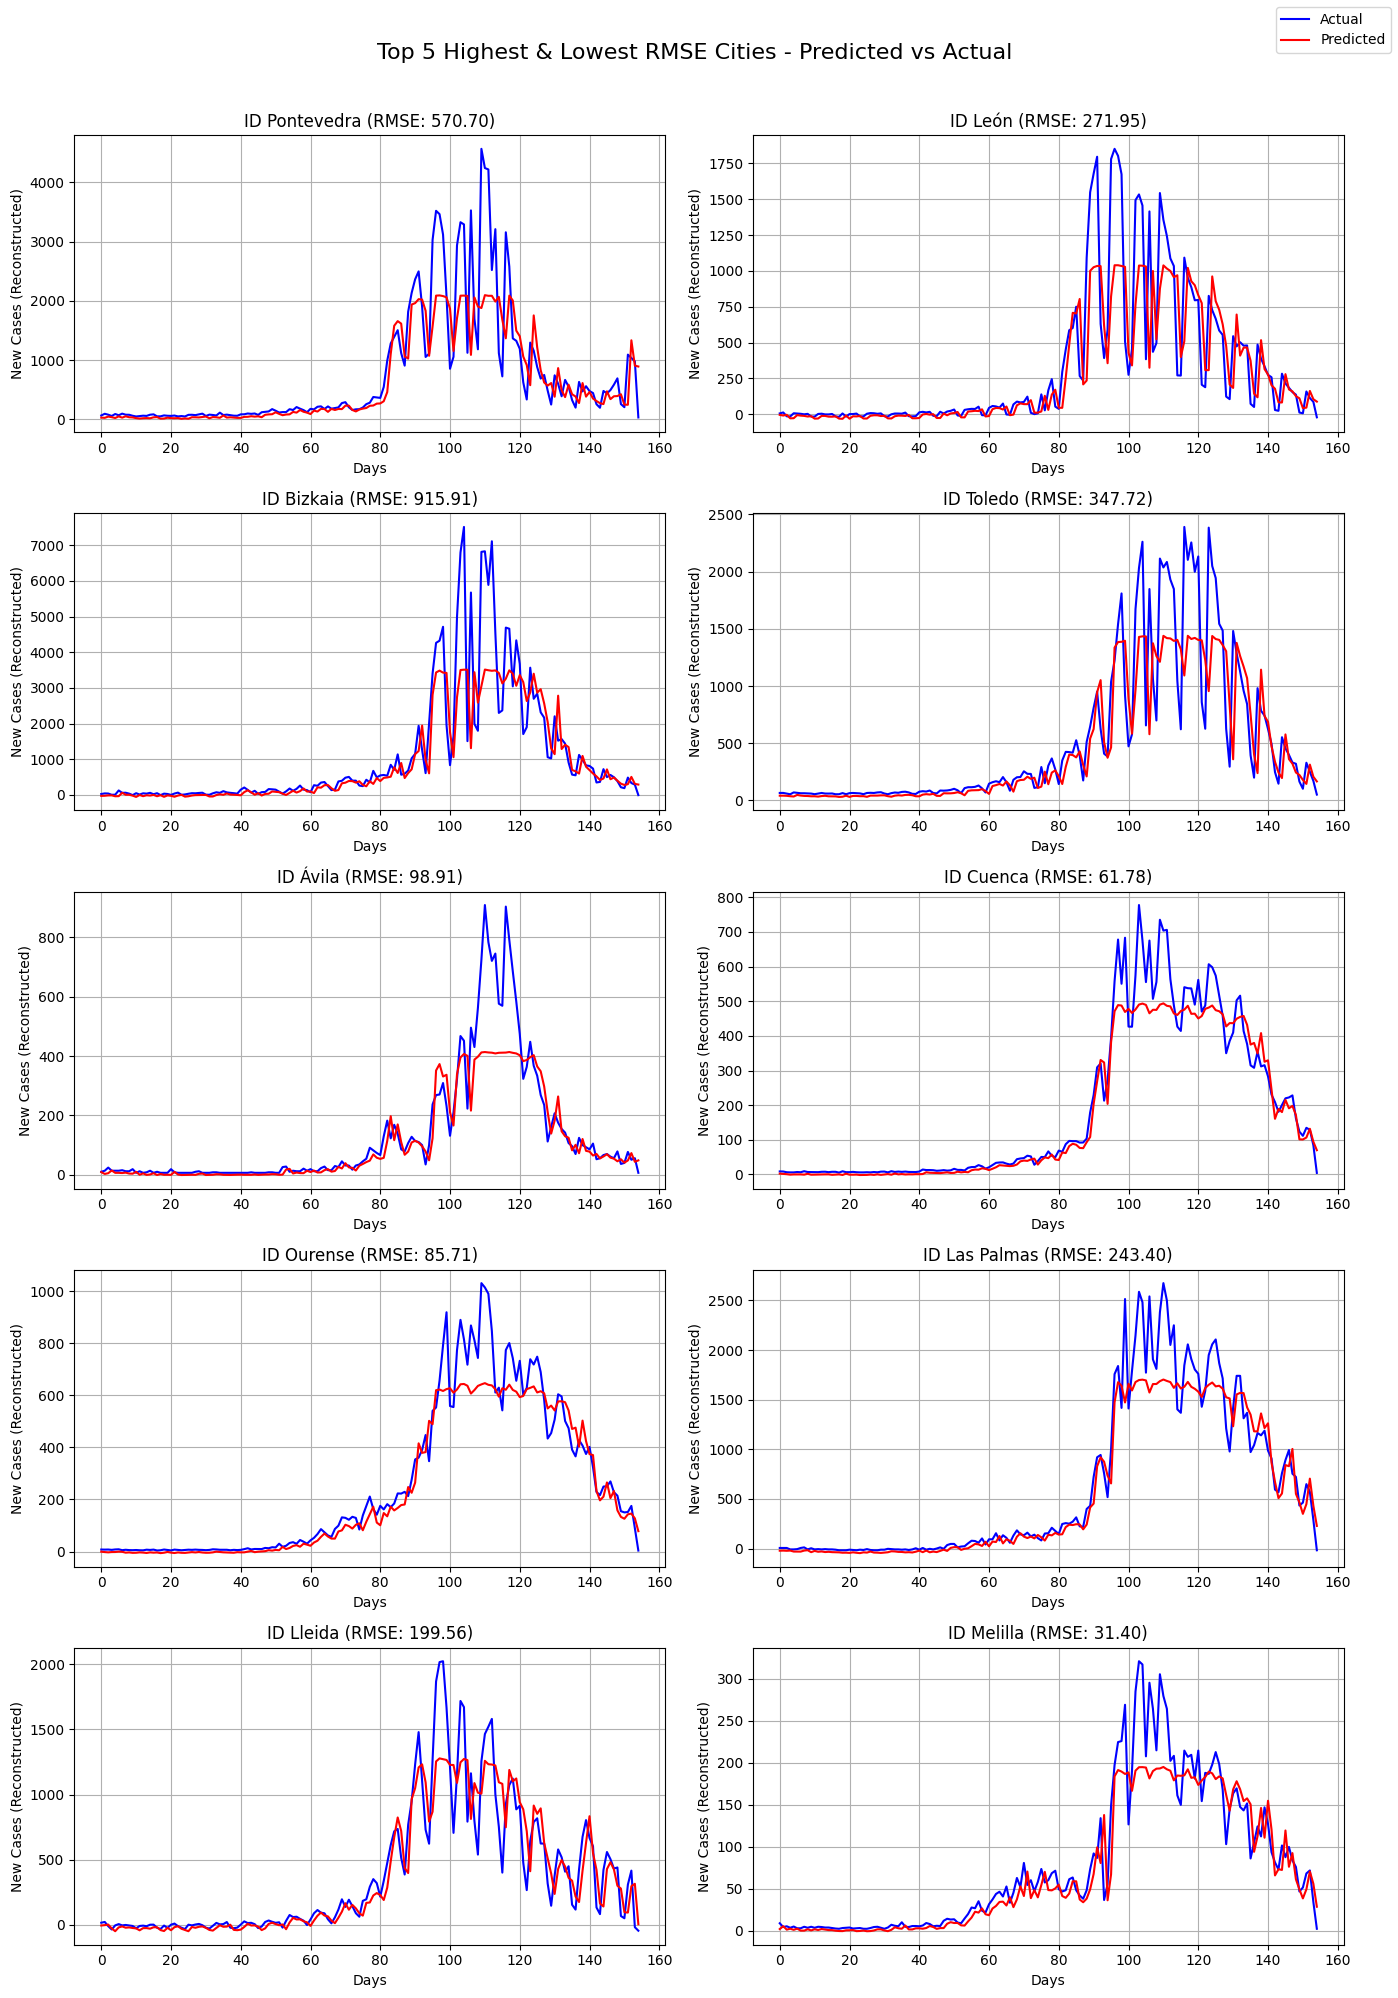

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Compute RMSE per city
city_rmses = []
for i, city_id in enumerate(city_id_list):
    actual = actual_array[:, i]
    pred = pred_array[:, i]
    rmse = np.sqrt(mean_squared_error(actual, pred))
    city_rmses.append((city_id, rmse))

# Step 2: Sort and get top 5 and bottom 5
top_5 = sorted(city_rmses, key=lambda x: x[1], reverse=True)[:5]
bottom_5 = sorted(city_rmses, key=lambda x: x[1])[:5]

# Step 3: Create mapping from city ID to name
id_to_name = dict(zip(centrality_df['Codmundv'], centrality_df['nomemun']))

# Step 4: Plotting helper
def plot_city_prediction(city_id, ax):
    city_name = id_to_name.get(city_id, f"ID {city_id}")
    city_index = city_id_list.index(city_id)

    # Get Z-scored predictions and actuals
    pred_z = pred_array[:, city_index]
    actual_z = actual_array[:, city_index]

    # Compute mean & std from original covid_df
    city_data = df_covid[df_covid['provincia'] == city_id].copy()
    city_data['Casos'] = city_data['Casos'].clip(lower=0)
    mean = city_data['Casos'].mean()
    std = city_data['Casos'].std(ddof=0)

    # Invert Z-score to get original scale
    pred = pred_z * std + mean
    actual = actual_z * std + mean

    # Plot
    ax.plot(actual, label='Actual', color='blue')
    ax.plot(pred, label='Predicted', color='red')
    rmse = np.sqrt(mean_squared_error(actual, pred))
    ax.set_title(f"{city_name} (RMSE: {rmse:.2f})")
    ax.set_xlabel("Days")
    ax.set_ylabel("New Cases (Reconstructed)")
    ax.grid(True)


# Step 5: Plot all 10 cities
fig, axs = plt.subplots(5, 2, figsize=(14, 20))
fig.suptitle("Top 5 Highest & Lowest RMSE Cities - Predicted vs Actual", fontsize=16)

for i, (city_id, _) in enumerate(top_5 + bottom_5):
    ax = axs[i // 2, i % 2]
    plot_city_prediction(city_id, ax)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout(rect=[0, 0, 0.98, 0.97])
plt.show()


In [149]:
import os
import torch

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/Global-Spatiotemporal-Spain-Current-Best-0-7903.pth")

In [150]:
last_input = X_test_slide[-1].unsqueeze(0).to(device)  # [1, T, N, 1]

In [166]:
forecast_horizon = 14
forecasted = []

current_input = last_input  # shape: [1, T, N, 1]

model.eval()
with torch.no_grad():
    for _ in range(forecast_horizon):
        pred = model(current_input, edge_index, edge_weight, node_features=pyg_data.x.to(device))  # [1, N, 1]
        forecasted.append(pred.squeeze(0).cpu())  # [N, 1] → [N]

        # Append prediction to input window (remove first day)
        next_input = torch.cat([current_input[:, 1:], pred.unsqueeze(1)], dim=1)  # keep shape [1, T, N, 1]
        current_input = next_input


In [167]:
forecasted = torch.stack(forecasted, dim=0)  # [30, N]

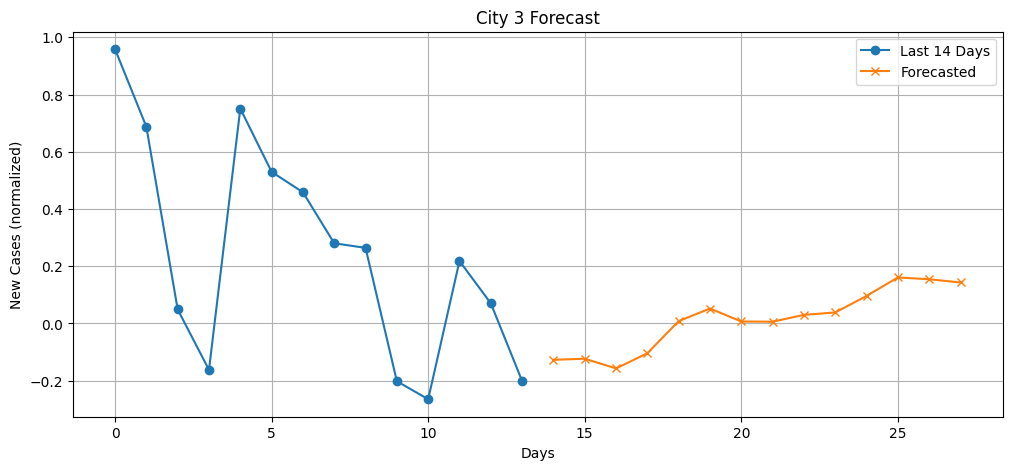

In [169]:
import matplotlib.pyplot as plt

city_idx = 3  # change this to visualize other cities
plt.figure(figsize=(12, 5))

# Plot actual recent values
recent = last_input[0, :, city_idx, 0].cpu().numpy()
plt.plot(range(len(recent)), recent, label="Last 14 Days", marker='o')

# Plot forecast
plt.plot(range(len(recent), len(recent) + forecast_horizon),
         forecasted[:, city_idx], label="Forecasted", marker='x')

plt.title(f"City {city_idx} Forecast")
plt.xlabel("Days")
plt.ylabel("New Cases (normalized)")
plt.legend()
plt.grid(True)
plt.show()
